# Gaussian process regression - hands on implementation

## Overview

Disclaimer: Original notebook from https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification @fabrang-paretos

This notebook contains a complete implementation of a Gaussian Process Regressor (GPR) with a squared exponential kernel using Numpy for matrix operations and Plotly for visualisation. 

The purpose of this notebook is to understand the main components of a GPR and to visualise the effects of certain parameters on the output. 
It is _not_ intended as a theoretical introduction to GPRs.
A good introduction can be found [here](http://www.gaussianprocess.org/gpml/chapters/RW.pdf). 

Stable and effective implementations of GPR's are available, for example, in the [gpytorch](https://gpytorch.ai) package.

## Packages

In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

## Plotting helper functions

To have nice visualizations of the later GPR, we use Plotly and to have structured and lean code, we define a few commonly used 'helpers' here. 

In [2]:
def update_layout_of_graph(fig: go.Figure,title: str = 'Plot')->go.Figure:
    fig.update_layout(
        width=800,
        height=600,
        autosize=False,
        plot_bgcolor='rgba(0,0,0,0)',
        title=title,
        
    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                      xaxis_title = 'input values',
                      yaxis_title = 'output values',
                      legend=dict(yanchor="top",
                                  y=0.3,
                                  xanchor="right",
                                  x=0.95),
                      title={
                          'x': 0.5,
                          'xanchor': 'center'
                      })
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
    return fig

In [3]:
def line_scatter(
    visible: bool = True,
    x_lines: np.array = np.array([]),
    y_lines: np.array = np.array([]),
    name_line: str = 'Predicted function',
    showlegend: bool = True,
) -> go.Scatter:
    # Adding the lines
    return go.Scatter(
        visible=visible,
        line=dict(color="blue", width=2),
        x=x_lines,
        y=y_lines,
        name=name_line,
        showlegend= showlegend
    )

In [4]:
def dot_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Observed points',
    showlegend: bool = True
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        name=name_dots,
        marker=dict(color='red', size=8),
        showlegend=showlegend
    )

In [5]:
def dot_scatter2(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'True function',
    showlegend: bool = True
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        line=dict(color="pink", width=2),
#        mode="markers",
        name=name_dots,
#        marker=dict(color='red', size=8),
        showlegend=showlegend
    )

In [6]:
def uncertainty_area_scatter(
        visible: bool = True,
        x_lines: np.array = np.array([]),
        y_upper: np.array = np.array([]),
        y_lower: np.array = np.array([]),
        name: str = "mean plus/minus standard deviation",
) -> go.Scatter:

    return go.Scatter(
        visible=visible,
        x=np.concatenate((x_lines, x_lines[::-1])),  # x, then x reversed
        # upper, then lower reversed
        y=np.concatenate((y_upper, y_lower[::-1])),
        fill='toself',
        fillcolor='rgba(189,195,199,0.5)',
        line=dict(color='rgba(200,200,200,0)'),
        hoverinfo="skip",
        showlegend=True,
        name= name,
    )

In [7]:
def add_slider_GPR(figure: go.Figure, parameters):
    figure.data[0].visible = True
    figure.data[1].visible = True

    # Create and add slider
    steps = []
    for i in range(int((len(figure.data) - 1) / 2)):
        step = dict(
            method="update",
            label=f'{parameters[i]: .2f}',
            args=[{
                "visible": [False] * (len(figure.data) - 1) + [True]
            }],
        )
        step["args"][0]["visible"][2 *
                                   i] = True  # Toggle i'th trace to "visible"
        step["args"][0]["visible"][2 * i + 1] = True
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps,
    )]
    figure.update_layout(sliders=sliders, )
    return figure

In [8]:
def add_slider_to_function(figure:go.Figure, parameters):
    figure.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(figure.data)):
        step = dict(
            method="update",
            label=f'{parameters[i]: .2f}',
            args=[{
                "visible": [False] *len(figure.data) 
            }],
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps,
    )]
    figure.update_layout(sliders=sliders, )
    return figure

## Implementation of GPR with squared exponential kernel

In order to define a gaussian process regressor (GPR) we need a covariance function (also called kernel). The choice of this function will determine the 'shape' of the later GPR. 

In this notebook we choose the popular _squared exponential_ kernel:
$$ k(x_1,x_2):= \sigma^2*\exp(-\|x_1-x_2\|^2_2)/(2*l^2))$$
with $$l>0$$ the lengthscale and $$\sigma^2>0$$ the signal variance. 
You are encouraged to implement a different kernel and see the difference in the resulting GPR!



In [9]:
class SquaredExponentialKernel:
    def __init__(self, sigma_f: float = 1, length: float = 0.5):
        self.sigma_f = sigma_f
        self.length = length

    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        return float(self.sigma_f *
                     np.exp(-(np.linalg.norm(argument_1 - argument_2)**2) /
                            (2 * self.length**2)))

Let us visualize this kernel.

In [10]:
x_lines = np.arange(-10, 10, 0.1)
kernel = SquaredExponentialKernel(length=1)

fig0 = go.FigureWidget(data=[
    line_scatter(
        x_lines=x_lines,
        y_lines=np.array([kernel(x, 0) for x in x_lines]),
    )
])

fig0 = update_layout_of_graph(fig0, title='Squared exponential kernel')


@interact(length=(0.1, 3, 0.1), sigma_f=(1, 5, 0.5))
def update(length=1, sigma_f=1):
    with fig0.batch_update():
        kernel = SquaredExponentialKernel(length=length, sigma_f=sigma_f)
        fig0.data[0].y = np.array([kernel(x, 0) for x in x_lines])

fig0.update_yaxes(range=(0, 5.0))
fig0
#fig0.write_image("fig1.png", scale=2)

interactive(children=(FloatSlider(value=1.0, description='length', max=3.0, min=0.1), FloatSlider(value=1.0, d…

FigureWidget({
    'data': [{'line': {'color': 'blue', 'width': 2},
              'name': 'Predicted function',
              'showlegend': True,
              'type': 'scatter',
              'uid': '6f90cd0f-044d-415d-8031-e8d0f68edd85',
              'visible': True,
              'x': array([-1.00000000e+01, -9.90000000e+00, -9.80000000e+00, -9.70000000e+00,
                          -9.60000000e+00, -9.50000000e+00, -9.40000000e+00, -9.30000000e+00,
                          -9.20000000e+00, -9.10000000e+00, -9.00000000e+00, -8.90000000e+00,
                          -8.80000000e+00, -8.70000000e+00, -8.60000000e+00, -8.50000000e+00,
                          -8.40000000e+00, -8.30000000e+00, -8.20000000e+00, -8.10000000e+00,
                          -8.00000000e+00, -7.90000000e+00, -7.80000000e+00, -7.70000000e+00,
                          -7.60000000e+00, -7.50000000e+00, -7.40000000e+00, -7.30000000e+00,
                          -7.20000000e+00, -7.10000000e+00, -7.00000000

In the practical implementation of the GPR you will face a couple of stability problems. Among others, numeric approximations in dealing with matrix (operations) may lead to non-invertible/non-positive-semi-definite covariance matrices which result in errors when calculating the GPR. 

In order to prevent this error we add the _machine epsilon_ to the diagonal of the later covariance matrix:

In [11]:
#fig0.write_image("fig2.png", scale=2)
print(np.finfo(float).eps)
# 2.22044604925e-16

print(np.finfo(np.float32).eps)
# 1.19209e-07

2.220446049250313e-16
1.1920929e-07


Let us shortly recall the formula:
Given training points $x_1,...,x_n\in \mathbb{R}^m$ with values $y_1,...,y_n\in \mathbb{R}$, $y = (y_i)\in \mathbb{R}^n$ with noise in each point $\mathcal{N}_{0,\sigma}$  and points $x_{n+1},...,x_k\in \mathbb{R}^m$ for which we want to predict the output, adapting our probability distribution leads to:

$$\mathcal{N}(K_*K^{-1}y,K_{**}-K_*K^{-1}K_*^T)$$
with 
$$K= (k(x_i,x_j))_{i,j\leq n}+\sigma^2*\mathbb{1}_n$$
$$K_*= (k(x_i,x_j))_{n+1\leq i, j\leq n}$$
$$K_{**}= (k(x_i,x_j))_{n+1\leq i,j}$$

In [12]:
# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function) -> np.array:
    return np.array([[cov_function(a, b) for a in x1] for b in x2])

In [13]:
class GPR:
    def __init__(self,
                 data_x: np.array,
                 data_y: np.array,
                 covariance_function=SquaredExponentialKernel(),
                 white_noise_sigma: float = 0):
        self.noise = white_noise_sigma
        self.data_x = data_x
        self.data_y = data_y
        self.covariance_function = covariance_function

        # Store the inverse of covariance matrix of input (+ machine epsilon on diagonal) since it is needed for every prediction
        self._inverse_of_covariance_matrix_of_input = np.linalg.inv(
            cov_matrix(data_x, data_x, covariance_function) +
            (3e-7 + self.noise) * np.identity(len(self.data_x)))

        self._memory = None

    # function to predict output at new input values. Store the mean and covariance matrix in memory.

    def predict(self, at_values: np.array) -> np.array:
        k_lower_left = cov_matrix(self.data_x, at_values,
                                  self.covariance_function)
        k_lower_right = cov_matrix(at_values, at_values,
                                   self.covariance_function)

        # Mean.
        mean_at_values = np.dot(
            k_lower_left,
            np.dot(self.data_y,
                   self._inverse_of_covariance_matrix_of_input.T).T).flatten()

        # Covariance.
        cov_at_values = k_lower_right - \
            np.dot(k_lower_left, np.dot(
                self._inverse_of_covariance_matrix_of_input, k_lower_left.T))

        # Adding value larger than machine epsilon to ensure positive semi definite
        cov_at_values = cov_at_values + 3e-7 * np.ones(
            np.shape(cov_at_values)[0])

        var_at_values = np.diag(cov_at_values)

        self._memory = {
            'mean': mean_at_values,
            'covariance_matrix': cov_at_values,
            'variance': var_at_values
        }
        return mean_at_values

That's it. The GPR is ready to be used! 

## Testing

Let us initialize our GPR on a random training set and visualize the GPR. 

In [14]:
def simple_fps(datax, nsamples):
    n=len(datax)
    distances=np.zeros(n)
    sampled=np.zeros((nsamples,), dtype=int)
    distances[:]=1e10
    index=np.random.choice(1, 1, replace=False)
    sampled[0]=index
    for i in range(nsamples):
        for j in range(n):
            dist=np.abs(datax[j]-datax[index])
            if dist <= distances[j]:
                distances[j]=dist
        index=np.argmax(distances)
        # print(index)
        sampled[i]=index
    return sampled
    

### Initializing training data

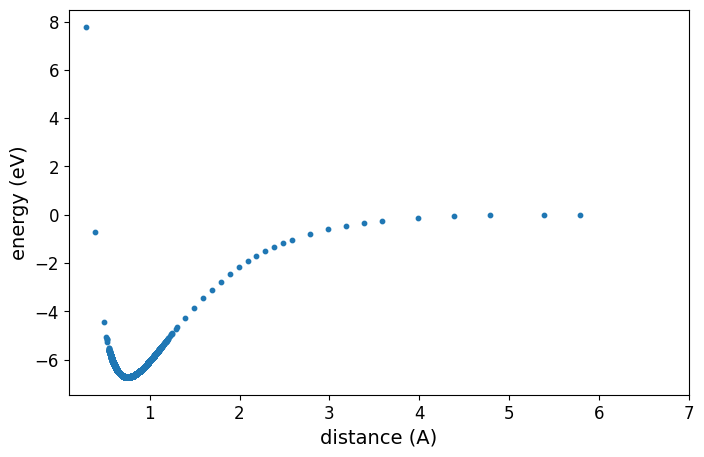

In [15]:
fulldata = np.loadtxt('dists-energies/combineddata.dat')
fullx = fulldata.T[0]
fully = fulldata.T[1]
zero=fully[-1]
fully = fully - zero
curvedata = np.loadtxt('dists-energies/datasmall.dat')
curvex = curvedata.T[0]
curvey = curvedata.T[1]
curvey = curvey - zero
plt.figure(figsize=(8, 5))
plt.xlim([0.1,7.0])
plt.scatter(fullx, fully, marker='o', s=10)
plt.ylabel('energy (eV)', fontsize=14)
plt.xlabel('distance (A)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.scatter(curvex, curvey, marker='o', s=50)
plt.show()

### Selecting points randomly

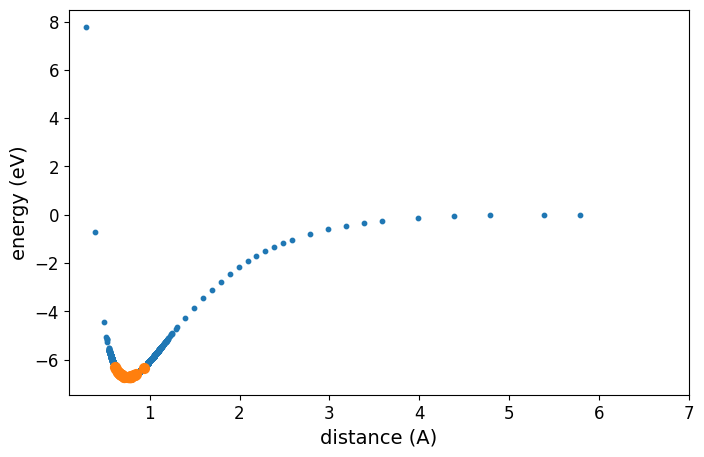

In [20]:
nsamples = 30
# Check if nsamples is not greater than the length of the array
if nsamples > len(fullx):
    raise ValueError("nsamples cannot be greater than the length of the array.")
# Draw nsample random indices
indices = np.random.choice(len(fullx), nsamples, replace=False)
# Select items from your array using these indices
selected_x = fullx[indices]
selected_y = fully[indices]
#x_values = np.array([0, 0.3, 1, 3.1, 4.7])
#y_values = np.array([1, 0, 1.4, 0, -0.9])
x_valuesrando=selected_x
y_valuesrando=selected_y
plt.figure(figsize=(8, 5))
plt.xlim([0.1,7.0])
plt.scatter(fullx, fully, marker='o', s=10)
plt.scatter(x_valuesrando, y_valuesrando, marker='o', s=50)
plt.ylabel('energy (eV)', fontsize=14)
plt.xlabel('distance (A)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

### Selecting by FPS

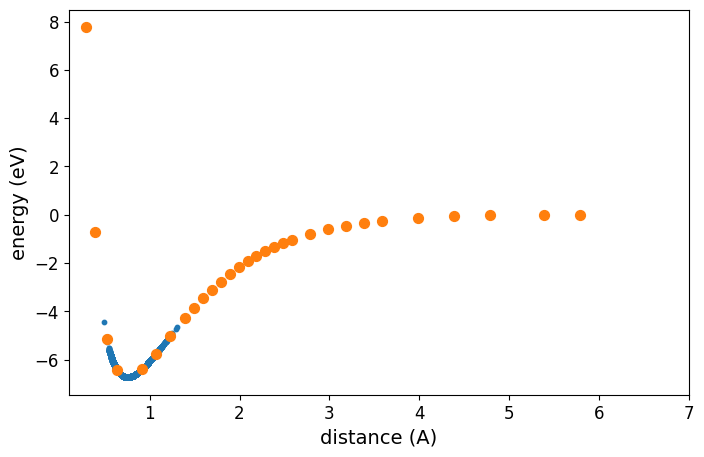

In [21]:
nsamples = 30
# Check if nsamples is not greater than the length of the array
if nsamples > len(fullx):
    raise ValueError("nsamples cannot be greater than the length of the array.")
# Call fps
indices = simple_fps(fullx, nsamples)
# print(indices)
# Select items from your array using these indices
selected_x_fps = fullx[indices]
selected_y_fps = fully[indices]
#x_values = np.array([0, 0.3, 1, 3.1, 4.7])
#y_values = np.array([1, 0, 1.4, 0, -0.9])
x_values=selected_x_fps
y_values=selected_y_fps
plt.figure(figsize=(8, 5))
plt.xlim([0.1,7.0])
plt.ylabel('energy (eV)', fontsize=14)
plt.xlabel('distance (A)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.scatter(fullx, fully, marker='o', s=10)
plt.scatter(x_values, y_values, marker='o', s=50)
plt.show()

In [22]:
x = np.arange(0.1,7,0.05)
#x = np.arange(-1,7,0.1)

### Plot the output

Let us define a helper function which returns a list of all plots of data points, mean, etc. needed to plot a GPR.

In [23]:
def plot_GPR(data_x, data_y, model, x, visible=True) -> list:
    mean = model.predict(x)

    std = np.sqrt(model._memory['variance'])
    data = []

    for i in range(1, 4):
        data.append(
            uncertainty_area_scatter(
                x_lines=x,
                y_lower=mean - i * std,
                y_upper=mean + i * std,
                name=f"mean plus/minus {i}*standard deviation",
                visible=visible))

    data.append(line_scatter(x_lines=x, y_lines=mean, visible=visible))
    data.append(dot_scatter(x_dots=data_x, y_dots=data_y, visible=visible))
    data.append(dot_scatter2(x_dots=curvex, y_dots=curvey, visible=visible))
    return data

Now, we can visualize our first GPR.

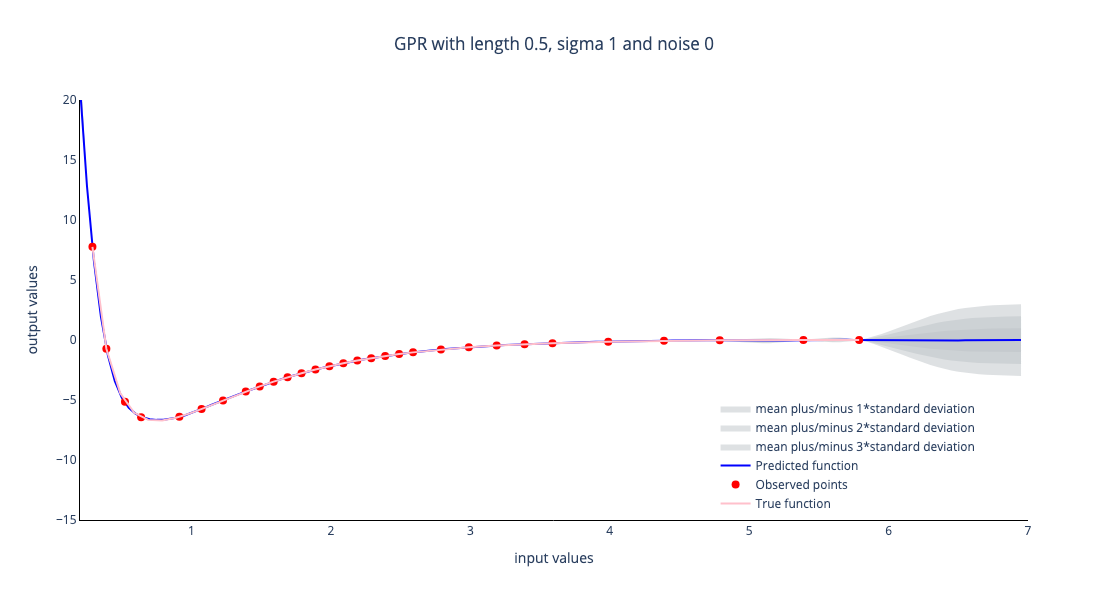

In [33]:
model = GPR(x_values[:], y_values[:])
#model = GPR([-10], [10])
data = plot_GPR(data_x=x_values, data_y=y_values, x=x, model=model)
fig4 = go.Figure(data=data)
fig4 = update_layout_of_graph(fig=fig4,
                              title='GPR with length 0.5, sigma 1 and noise 0')
fig4.update_xaxes(
    range=(0.2, 7.0))
fig4.update_yaxes(
    range=(-15, 20.0))
fig4.show()

A cool feature of the GPR is that it is sort of a probability distribution over function - so we can literally 'draw' random functions!

In [35]:
#model = GPR([-10],[-10])
model = GPR(x_values[:2], y_values[:2])
#model = GPR(x_values[:], y_values[:])

mean = model.predict(x)
covariance_matrix = model._memory['covariance_matrix']

fig1 = go.FigureWidget(data=[dot_scatter(x_dots=x_values, y_dots=y_values)])
fig1 = update_layout_of_graph(
    fig1,
    title='Random drawings (i.e. random functions) of the Gaussian process')

button = widgets.Button(description='Add random drawing')


def update(_):
    with fig1.batch_update():
        fig1.add_trace(
            line_scatter(x_lines=x,
                         y_lines=np.random.multivariate_normal(
                             mean, covariance_matrix),
                         name_line='random function',
                         showlegend=False))
        fig1.add_trace(
            dot_scatter(x_dots=x_values, y_dots=y_values, showlegend=False))
        fig1.add_trace(
            dot_scatter2(x_dots=curvex, y_dots=curvey, showlegend=False))


button.on_click(update)
widgets.VBox([fig1, button])

    'data': [{'marker': {'color': 'red', 'size': 8},
              'mode': 'mark…

Doing predictions with a GPR is usually done by taking the mean function as our best guess. Since GPR's are a probabilistic model, we get in addition some sort of certainty of our prediction. (But be careful how to interpret this uncertainty area! Believing that every 'new' point must be in the uncertainty area is simply wrong!)

In [36]:
#model = GPR([-10], [-10])
model = GPR(x_values[:1], y_values[:1])

data = plot_GPR(data_x=[-10], data_y=[-10], x=x, model=model)
#data = plot_GPR(data_x=x_values[:1], data_y=y_values[:1], x=x, model=model)


fig2 = go.FigureWidget(data=data)
fig2 = update_layout_of_graph(fig2, title='Prediction (i.e. mean) of GPR')
fig2.update_xaxes(range=(0.2, 7.0))
fig2.update_yaxes(range=(-15, 20.0))

button = widgets.Button(description='Add data point')

number_of_points = 1

# we update the y values of our 4 scatter plots 
def update(_):
    with fig2.batch_update():
        global number_of_points
        if number_of_points <= len(x_values):
            model = GPR(x_values[:number_of_points],
                        y_values[:number_of_points])
            mean = model.predict(x)
            fig2.data[3].y = mean
            for i in range(1, 4):
                y_upper = mean + i * np.sqrt(model._memory['variance'])
                y_lower = mean - i * np.sqrt(model._memory['variance'])
                fig2.data[i - 1].y = np.concatenate((y_upper, y_lower[::-1]))

            fig2.data[4].x = x_values[:number_of_points]
            fig2.data[4].y = y_values[:number_of_points]
            fig2.update_xaxes(range=(0.2, 7.0))
            fig2.update_yaxes(range=(-15, 20.0))
            number_of_points += 1


button.on_click(update)
widgets.VBox([fig2, button])

    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(189,195,199,0.5…

You can test the GPR with different data. Try using multi-dimensional input!

### Visualization of effect of free parameters

Awesome! Now that we can make predictions with our GPR, lets visualize how the GPR changes if we change the free parameters, i.e. length-scale, variance and white noise.

In [37]:
model = GPR(x_values,
            y_values,
            covariance_function=SquaredExponentialKernel(length=0.5),
            white_noise_sigma=0.1)

data = plot_GPR(x_values, y_values, model=model, x=x)

fig3 = go.FigureWidget(data=data)
fig3.update_xaxes(range=(0.2, 7.0))
fig3.update_yaxes(range=(-15, 20.0))


# we update the y values of our 4 scatter plots 
@interact(sigma=(0.01, 3, 0.01), length=(0.01, 3, 0.01), noise=(0.000, 1.000, 0.0001))

def update(sigma=1, length=0.5, noise=0.0005):
    with fig3.batch_update():
        model = GPR(x_values,
                    y_values,
                    covariance_function=SquaredExponentialKernel(
                        sigma_f=sigma, length=length),
                    white_noise_sigma=noise)

        mean = model.predict(x)
        y_upper = mean + np.sqrt(model._memory['variance'])
        y_lower = mean - np.sqrt(model._memory['variance'])

        
        for i in range(1, 4):
            y_upper = mean + i * np.sqrt(model._memory['variance'])
            y_lower = mean - i * np.sqrt(model._memory['variance'])
            fig3.data[i-1].y = np.concatenate((y_upper, y_lower[::-1]))
            fig3.update_xaxes(range=(0.2, 7.0))
            fig3.update_yaxes(range=(-15, 20.0))
        
        fig3.data[3].y = mean


fig3 = update_layout_of_graph(
    fig3, title="GPR with varying length, sigma and white noise")
fig3.update_xaxes(range=(0.2, 7.0))
fig3.update_yaxes(range=(-15, 20.0))
fig3

interactive(children=(FloatSlider(value=1.0, description='sigma', max=3.0, min=0.01, step=0.01), FloatSlider(v…

FigureWidget({
    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(189,195,199,0.5)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(200,200,200,0)'},
              'name': 'mean plus/minus 1*standard deviation',
              'showlegend': True,
              'type': 'scatter',
              'uid': '99878aaa-ac7a-4730-b88f-9914efbbe840',
              'visible': True,
              'x': array([0.1 , 0.15, 0.2 , ..., 0.2 , 0.15, 0.1 ]),
              'y': array([24.74658478, 19.80240057, 14.96909988, ..., 14.86527935, 19.64040918,
                          24.51068584])},
             {'fill': 'toself',
              'fillcolor': 'rgba(189,195,199,0.5)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(200,200,200,0)'},
              'name': 'mean plus/minus 2*standard deviation',
              'showlegend': True,
              'type': 'scatter',
              'uid': '3750a937-6fb2-4316-b1fd-f2517df59cde',
              'vi

Pretty impressive how many function 'shapes' we can generate with a GPR!

But now we naturally raise the question:

_What are the best parameters for our GPR and problem?_

#### Can train aquisition function a(x) = meanGPR(x) - kappa*sqrt(variance(x)) - the minimum position is how you choose next point

In [24]:
#### Hyperparam optimization in GPR: 